### Датасет классификации "Пульсары"

О датасете
Этот датасет содержит параметры, которые характеризуют наблюдения за пульсарами. Включает такие переменные, как "Mean_Integrated", "EK", "Skewness", элементов кривой DMSNR (дисперсия, эксцесс, асимметрия) и целевой класс. Данные предназначены для задач классификации, где цель — предсказать, является ли объект пульсаром или нет, на основе предоставленных характеристик.

Актуальность
Классификация пульсаров является важной задачей в астрофизике, поскольку позволяет выделять истинные сигналы пульсаров среди большого количества ненужных данных. Это способствует более точному изучению таких астрономических объектов и их использования для других исследований. Обработка данных такого типа может также способствовать разработке более мощных алгоритмов классификации, используемых в других областях, где проблема соотношения сигнал/шум является критичной.

Выбранная метрика
Поскольку классы будут распределены в соотношении 1:1, стандартные метрики классификации, такие как точность (accuracy), могут быть использованы для оценки моделей. Однако, учитывая природу задачи и потенциал экономии ресурсов при переработке большого количества астрономических данных, также целесообразно рассмотреть применение F1-меры, особенно если в реальных данных может быть дисбаланс классов, но сейчас нам не нужен такой большой датасет, поэтому будет достаточно обрезать его для равенства классов.


### Датасет регрессии "Предсказание роста ребенка"

О датасете:  
Этот датасет содержит информацию, необходимую для предсказания роста ребенка на основе данных о его поле и росте родителей. В нем представлены такие параметры, как пол ребенка, рост отца и рост матери. Эти данные позволяют анализировать взаимосвязь между генетическими факторами и ростом ребенка.

Актуальность:  
Предсказание роста ребенка является актуальной задачей в области педиатрии и генетики. Оценка будущего роста на основании наследственных факторов может быть полезна для врачей и родителей, помогая им следить за развитием ребенка и принимать обоснованные решения в случае необходимости.

Метрика:  
Для задачи предсказания роста ребенка наилучшей метрикой является среднеквадратичная ошибка (MSE). MSE позволяет количественно оценить, насколько предсказанный рост отклоняется от фактического, подчеркивая значительные отклонения. Такая метрика важна в контексте биологических данных, где каждая единица измерения имеет значение для оценки развития ребенка.

# Данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from scipy.spatial.distance import euclidean, cityblock, chebyshev
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor



### Классификация

загружаем датасет

In [103]:
pulsars = pd.read_csv("./pulsars.csv")
pulsars.head()

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,1.502969,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,0.788423,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,0.323558,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,0.958983,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,1.232198,1.123492,1.178930,11.468720,14.269573,252.567306,0


смотрим на распределение целевого столбца

Axes(0.125,0.11;0.775x0.77)


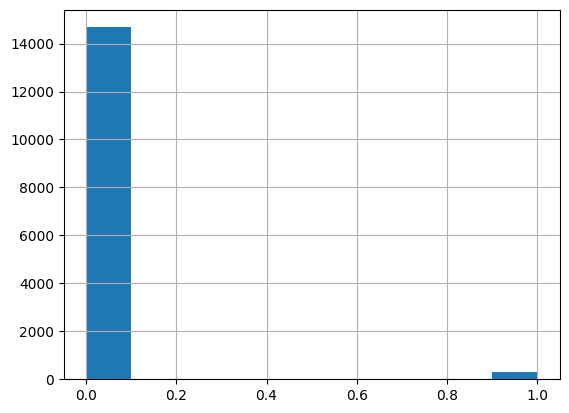

In [105]:
print(pulsars.Class.hist())

In [108]:
class_0 = pulsars[pulsars['Class'] == 0]
class_1 = pulsars[pulsars['Class'] == 1]

class_0_balanced = class_0.sample(n=len(class_1), random_state=42)

balanced_pulsars = pd.concat([class_0_balanced, class_1])

balanced_pulsars = balanced_pulsars.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_pulsars['Class'].value_counts())
pulsars = balanced_pulsars

Class
0    308
1    308
Name: count, dtype: int64


проверяем пустые значения

In [109]:
pulsars.isna().sum()

Mean_Integrated         0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

создадим корреляционную матрицу для датасета

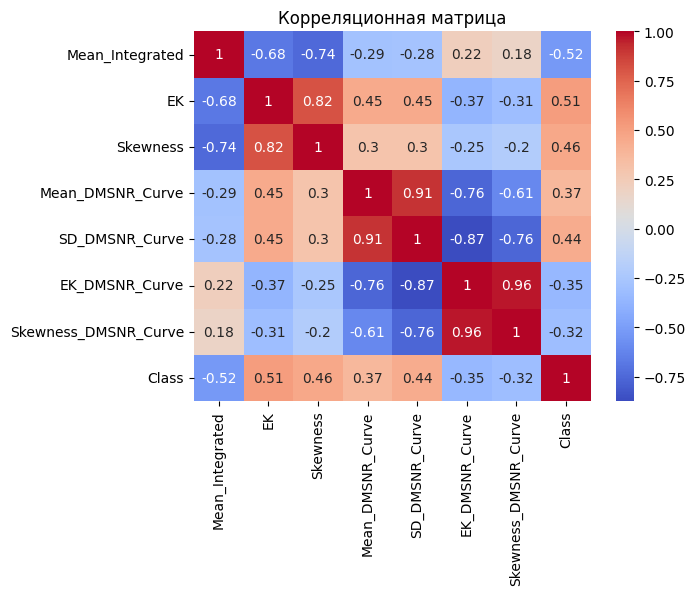

In [111]:
correlation_matrix = pulsars.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

На основе построенной корреляционной матрицы можно сделать следующие выводы:

1. Mean_Integrated: Имеет умеренно отрицательную корреляцию с классом (-0.52), что предполагает, что более высокие значения этого параметра чаще связаны с одним из классов.

2. EK и Skewness: Исходя из значений корреляции с классом (0.51 и 0.46 соответственно), видно, что они умеренно положительно коррелируют с ним, что может означать, что более высокие значения этих параметров связаны с другим классом.

3. Взаимосвязь характеристик DMSNR_Curve:
   - SD_DMSNR_Curve и Mean_DMSNR_Curve имеют самую сильную взаимную корреляцию (0.91), что может указывать на многоколлинеарность. Это стоит учесть при построении модели.
   - EK_DMSNR_Curve и Skewness_DMSNR_Curve также очень сильно коррелируют (0.96).



разбиваем датасет на выборки

In [113]:
pulsars_x = pulsars.drop('Class', axis=1)
pulsars_y = pulsars['Class']

pulsars_X_train, pulsars_X_test, pulsars_y_train, pulsars_y_test = train_test_split(pulsars_x, pulsars_y, test_size=0.2, random_state=228)

print(f"Размер обучающей выборки: {pulsars_X_train.shape}")
print(f"Размер тестовой выборки: {pulsars_X_test.shape}")

Размер обучающей выборки: (492, 7)
Размер тестовой выборки: (124, 7)


### Регрессия

загружаем датасет

In [9]:
heihgts = pd.read_csv('./heights.csv')

смотрим на данные в нём

In [10]:
heihgts.head()

,Father_height,Mother_height,Child_height,gender
0,78.5,67.0,73.2,1
1,78.5,67.0,69.2,0
2,78.5,67.0,69.0,0
3,78.5,67.0,69.0,0
4,75.5,66.5,73.5,1


проверяем пустые значения

In [11]:
heihgts.isna().sum()

Father_height    0
Mother_height    0
Child_height     0
gender           0
dtype: int64

создадим корреляционную матрицу для датасета

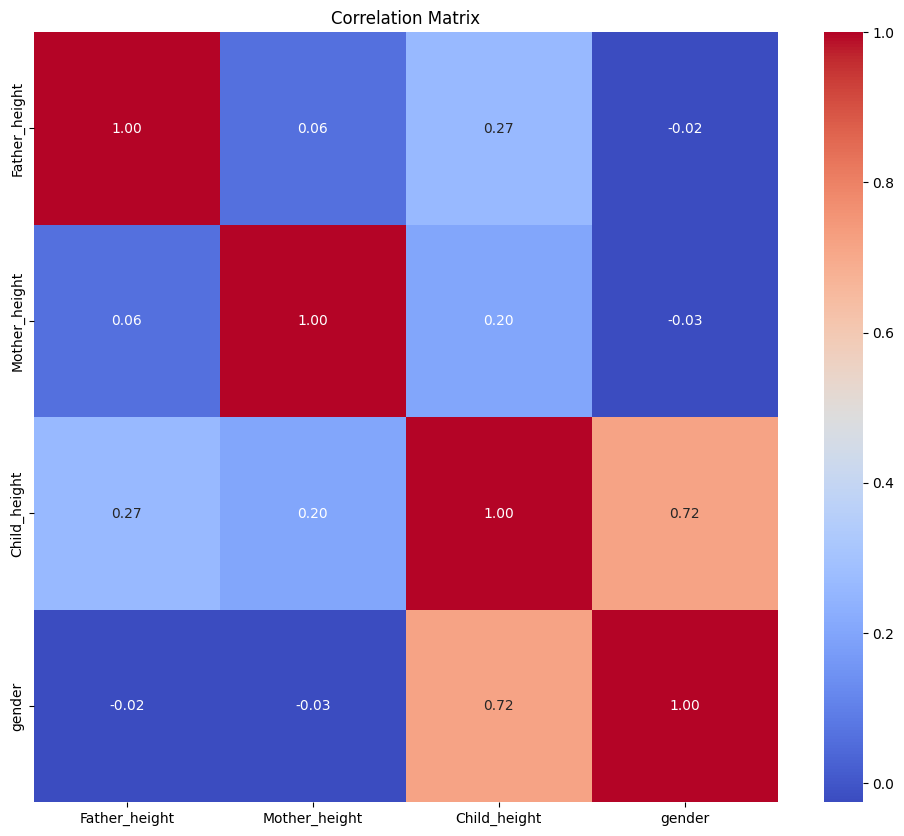

In [7]:
corr_matrix = heihgts.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


На основе корреляционной матрицы можно сделать следующие выводы:

Эта корректная корреляционная матрица отображает взаимосвязи между переменными: рост отца, рост матери, рост ребенка и пол ребенка.

1. Рост отца и рост ребенка (0.27): Умеренная положительная корреляция, что предполагает слабую зависимость между этими двумя параметрами.

2. Рост матери и рост ребенка (0.20): Похожая умеренная положительная корреляция, как и у отца, указывает на слабое влияние роста матери на рост ребенка.

3. Пол ребенка и рост ребенка (0.72): Сильная положительная корреляция, что может указывать на значительное влияние пола на рост.

4. Другие корреляции: Все остальные значения близки к нулю, что говорит об отсутствии значимой линейной зависимости.

Эти наблюдения помогут сосредоточиться на значимых факторах при построении модели регрессии для прогнозирования расходов на здоровье.

разбиваем датасет на выборки

In [12]:
heihgts_X = heihgts.drop('Child_height', axis=1)
heihgts_y = heihgts['Child_height']

heihgts_X_train, heihgts_X_test, heihgts_y_train, heihgts_y_test = train_test_split(heihgts_X, heihgts_y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {heihgts_X_train.shape}")
print(f"Размер тестовой выборки: {heihgts_X_test.shape}")

Размер обучающей выборки: (747, 3)
Размер тестовой выборки: (187, 3)


# Работа 1 (KNN)

## Классификация

### Бейзлайн классификации

In [121]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=20))
])


pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"KNN Baseline Accuracy: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

KNN Baseline Accuracy: 0.7580645161290323


#### Подбор параметров

запустим GridSearchCV для перебора гиперпараметров

In [122]:
param_grid = {
    'classifier__n_neighbors': range(2, 8),
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(accuracy_score))
grid_search.fit(pulsars_X_train, pulsars_y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность на кросс-валидации: {best_score}")

pulsars_y_pred = grid_search.predict(pulsars_X_test)
test_accuracy = accuracy_score(pulsars_y_test, pulsars_y_pred)
print(f"Точность на тестовом наборе: {test_accuracy}")

Лучшие параметры: {'classifier__n_neighbors': 6}
Лучшая точность на кросс-валидации: 0.7846217274788704
Точность на тестовом наборе: 0.7338709677419355


### Собственная имплементация

In [123]:
class KNNBase(BaseEstimator):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y)
        return self

    def _get_distance(self, a, b):
        if self.metric == 'euclidean':
            return euclidean(a, b)
        elif self.metric == 'manhattan':
            return cityblock(a, b)
        elif self.metric == 'chebyshev':
            return chebyshev(a, b)
        else:
            raise ValueError(f"Неизвестная метрика: {self.metric}")

    def _get_neighbors(self, x):
        distances = np.array([self._get_distance(x, xi) for xi in self.X_train])
        return np.argsort(distances)[:self.n_neighbors]


In [117]:
class KNNClassifier(KNNBase, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        super().__init__(n_neighbors=n_neighbors, metric=metric)

    def predict(self, X):
        X_test = np.array(X)
        predictions = []

        for x in X_test:
            nearest_indices = self._get_neighbors(x)
            nearest_values = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_values).argmax())

        return np.array(predictions)

#### Бейзлайн классификации

In [124]:
print(pulsars_X_test[:5])

     Mean_Integrated        EK  Skewness  Mean_DMSNR_Curve  SD_DMSNR_Curve  \
186       101.953125  0.791457  0.006462          7.671405       38.431365   
552       121.859375  0.073414 -0.249216          5.219900       27.884544   
211       118.132812  0.297014 -0.450082          1.423913       13.557510   
276       119.164062  0.118004  0.186684          2.877926       23.763505   
241       118.164062  0.851472 -0.443982         15.603679       48.412094   

     EK_DMSNR_Curve  Skewness_DMSNR_Curve  
186        5.150862             25.577309  
552        6.154451             40.295990  
211       11.854845            162.559510  
276        8.398196             70.439688  
241        3.065685              8.223163  


In [119]:
# Создание пайплайна
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', KNNClassifier(n_neighbors=4))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Custom KNN Baseline Accuracy: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Custom KNN Baseline Accuracy: 0.7419354838709677


#### Подбор параметров

запустим GridSearchCV для перебора гиперпараметров

In [125]:
param_grid = {
    'classifier__n_neighbors': range(2, 8),
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(accuracy_score))
grid_search.fit(pulsars_X_train, pulsars_y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность на кросс-валидации: {best_score}")

pulsars_y_pred = grid_search.predict(pulsars_X_test)
test_accuracy = accuracy_score(pulsars_y_test, pulsars_y_pred)
print(f"Точность на тестовом наборе: {test_accuracy}")

Лучшие параметры: {'classifier__metric': 'chebyshev', 'classifier__n_neighbors': 6}
Лучшая точность на кросс-валидации: 0.7967841682127397
Точность на тестовом наборе: 0.7661290322580645


## Регрессия

### Бейзлайн регрессии

In [30]:
numerical_features = ["Father_height","Mother_height","gender"]

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ]
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=3))
])


pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)
print(f"Sklearn KNN Baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn KNN Baseline MAE metric is: 1.874331550802139


#### Подбор параметров

будем перебирать число соседей в KNN а также модифицируем пайплайн - будем предобрабатывать численные данные путём нормирования, так как для подсчёта расстояния это будет важно в алгоритме.

In [31]:
param_grid = {
    'regressor__n_neighbors': range(2, 11)
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=3))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(heihgts_X_train, heihgts_y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая MAE: {best_score}")

y_pred = grid_search.predict(heihgts_X_test)
mae_optimized = mean_absolute_error(heihgts_y_test, y_pred)
print(f"Оптимизированная MAE на тестовом наборе: {mae_optimized}")

Лучшие параметры: {'regressor__n_neighbors': 6}
Лучшая MAE: 1.7884791946308725
Оптимизированная MAE на тестовом наборе: 1.689483065953654


Нормализация численных признаков с помощью StandardScaler также важна, особенно для алгоритмов, основанных на расстоянии, как KNN. Масштабирование данных приводит их к единому стандарту, снижая влияние признаков с большим разбросом и тем самым улучшая точность модели. 

В результате, благодаря оптимальному выбору гиперпараметров и предварительной обработке данных, модель даёт более точные прогнозы.


### Собственная имплементация

In [32]:
class KNNRegressor(KNNBase, RegressorMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        super().__init__(n_neighbors=n_neighbors, metric=metric)

    def predict(self, X):
        X_test = np.array(X)
        predictions = []

        for x in X_test:
            nearest_indices = self._get_neighbors(x)
            nearest_values = self.y_train[nearest_indices]
            predictions.append(np.mean(nearest_values))

        return np.array(predictions)

In [33]:
pipeline = Pipeline(steps=[
    ('regressor', KNNRegressor(n_neighbors=3))
])


pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)
print(f"Sklearn KNN Baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn KNN Baseline MAE metric is: 1.834046345811052


#### Подбор параметров

In [34]:
param_grid = {
    'regressor__n_neighbors': range(2, 11),
    'regressor__metric': ['euclidean', 'manhattan', 'chebyshev']
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNNRegressor(n_neighbors=3))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(heihgts_X_train, heihgts_y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая MAE: {best_score}")

y_pred = grid_search.predict(heihgts_X_test)
mae_optimized = mean_absolute_error(heihgts_y_test, y_pred)
print(f"Оптимизированная MAE на тестовом наборе: {mae_optimized}")

Лучшие параметры: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 10}
Лучшая MAE: 1.7758720357941837
Оптимизированная MAE на тестовом наборе: 1.6995187165775405


### Выводы

В случае использования готового классификатора из библиотеки и в случае с собственной реализацией алгоритма, удалось достичь сопоставимых уровней точности. Это говорит о том, что реализация справляется с задачей на уровне, сравнимом со стандартными библиотечными решениями. Собственная реализация предлагает использование метрики 'manhattan', что оказало положительное влияние на результаты. Так же важно и нормировать исходные данные для получание более точных прогнозов модели.


# Работа 2 (Linear Models)

In [61]:
def add_height_features(df):
    df['average_parent_height'] = (df['Father_height'] + df['Mother_height']) / 2
    df['parent_height_diff'] = abs(df['Father_height'] - df['Mother_height'])
    return df

In [126]:
def modify_pulsar_features(df):
    # Удаление одной из сильно коррелированных фичей. Например, SD_DMSNR_Curve
    df = df.drop(columns=['SD_DMSNR_Curve'])

    # Создание полиномиальных признаков
    df['Mean_Skewness_Product'] = df['Mean_Integrated'] * df['Skewness']
    df['EK_Skewness_Product'] = df['EK'] * df['Skewness']
    df['Mean_EK_Diff'] = abs(df['Mean_Integrated'] - df['EK'])
    df['DMSNR_Interaction'] = df['Mean_DMSNR_Curve'] * df['EK_DMSNR_Curve']
    return df


## Классификация

### Бейзлайн классификации

In [127]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Sklearn Linear Logistic accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Sklearn Linear Logistic accuracy_score metric is: 0.7661290322580645


### Собственная имплементация

In [131]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=5e3, lr=0.04, tol=0.001, l1_coef=0.1):
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.l1_coef = l1_coef
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train):
        n, m = X_train.shape
        y_train = y_train.to_numpy().reshape(-1, 1)


        self.weights = np.zeros((m, 1))
        self.bias = np.mean(y_train)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tol:

            dJdw, dJdb = self.grads(X_train, y_train)

            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))

            self.weights = self.weights - self.lr * dJdw
            self.bias = self.bias - self.lr * dJdb

            n_iter += 1

        return self

    def predict(self, X):
        return list(map(lambda x: int(x[0] > 0.5), self.predict_proba(X)))


    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def grads(self, X, y):
        y_hat = self.predict_proba(X)

        dJdw = np.mean(X * (y_hat - y) + self.l1_coef * np.sign(self.weights.T), axis=0, keepdims=True).T
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))



In [132]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', MyLogisticRegression())
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Sklearn Linear Logistic accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")


Sklearn Linear Logistic accuracy_score metric is: 0.7580645161290323


#### Улучшение

In [133]:
new_pulsars_X_train = modify_pulsar_features(pulsars_X_train.copy())
new_pulsars_X_test = modify_pulsar_features(pulsars_X_test.copy())

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', MyLogisticRegression())
])

pipeline.fit(new_pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(new_pulsars_X_test)

print(f"Sklearn Linear Logistic accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")


Sklearn Linear Logistic accuracy_score metric is: 0.75


## Регрессия

### Бейзлайн регрессии

In [134]:
from sklearn.linear_model import LinearRegression


numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"Sklearn Linear baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn Linear baseline MAE metric is: 1.6874244143111958


### Собственная имплементация

In [64]:
class LinearRegressionImpl(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=5000, lr=0.04, tol=0.001, l1_coef=0.1):
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.l1_coef = l1_coef
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train):
        n, m = X_train.shape
        y_train = y_train.to_numpy().reshape(-1, 1)

        self.weights = np.zeros((m, 1))
        self.bias = np.mean(y_train)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tol:
            dJdw, dJdb = self.grads(X_train, y_train)
            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))
            self.weights -= self.lr * dJdw
            self.bias -= self.lr * dJdb

            n_iter += 1

        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def grads(self, X, y):
        y_hat = self.predict(X)

        dJdw = np.mean(X * (y_hat - y) + self.l1_coef * np.sign(self.weights.T), axis=0, keepdims=True).T
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb

In [135]:

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegressionImpl())
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)


print(f"Custom Linear baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")


Custom Linear baseline MAE metric is: 1.69415968417844


#### Улучшение

In [136]:
new_heihgts_X_train = add_height_features(heihgts_X_train.copy())
new_heihgts_X_test = add_height_features(heihgts_X_test.copy())

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegressionImpl())
])

pipeline.fit(new_heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(new_heihgts_X_test)


print(f"My Linear baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

My Linear baseline MAE metric is: 1.69415968417844


### Выводы

Собственная реализация логистической регрессии продемонстрировала результаты, близкие к тем, что получены с использованием библиотеки scikit-learn. Это свидетельствует о правильности и эффективности подхода, используемого в разработке алгоритма. Важность дополнительной информации: Результаты эксперимента показали, что добавление новых признаков не улучшает предсказательные возможности модели. Что подчеркивает не важность таких связей параметров датасета.

Перспективы улучшения: Несмотря на достигнутые результаты, существует потенциал для дальнейшего повышения точности и уменьшения ошибок модели. Это можно достичь за счет оптимизации параметров, внедрения альтернативных алгоритмов обучения и улучшенных методов предобработки данных.

# Работа 3 (Decision Tree)

## Классификация

### Бейзлайн классификации

In [137]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=69))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Sklearn DecisionTreeClassifier baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Sklearn DecisionTreeClassifier baseline accuracy_score metric is: 0.7580645161290323


#### Подбор гиперпараметров

In [138]:
param_distributions = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=1337,
    n_jobs=-1
)


random_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = random_search.predict(pulsars_X_test)
print(f"Tuned DecisionTreeClassifier accuracy_score: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

# Лучшие параметры
print("Best parameters found: ", random_search.best_params_)

Tuned DecisionTreeClassifier accuracy_score: 0.7419354838709677
Best parameters found:  {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy'}


### Собственная имплементация

In [139]:
class DecisionTreeClassifierImpl:
    def __init__(self, max_depth=None, max_features=None, min_samples_split=2, min_leaf_samples=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_leaf_samples = min_leaf_samples
        self._node = {
            'left': None,
            'right': None,
            'feature': None,
            'threshold': None,
            'depth': 0,
            'classes_proba': None
        }
        self.tree = None
        self.classes = None


    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = {'root': self._node.copy()}
        self._build_tree(self.tree['root'], X, y)
        return self

    def predict_proba(self, X):
        proba_preds = []
        for x in X:
            preds_for_x = self._get_predict(self.tree['root'], x)
            proba_preds.append(preds_for_x)
        return np.array(proba_preds)

    def predict(self, X):
        proba_preds = self.predict_proba(X)
        preds = proba_preds.argmax(axis=1).reshape(-1, 1)
        return preds

    def get_best_split(self, X, y):
        best_j = None
        best_t = None
        best_left_ids = None
        best_right_ids = None
        best_Q = float('-inf')

        for i in range(X.shape[1]):
            unique_features = np.unique(X[:, i])
            for j in range(len(unique_features) - 1):
                cur_threshold = (unique_features[j] + unique_features[j + 1]) / 2
                left_indexes = X[:, i] < cur_threshold
                left_children_y = y[left_indexes]
                right_children_y = y[~left_indexes]

                # Условие минимального числа объектов в листе
                if len(left_children_y) < self.min_samples_split or len(right_children_y) < self.min_samples_split:
                    continue

                cur_Q = self.calc_Q(y, left_children_y, right_children_y)
                if cur_Q > best_Q:
                    best_Q = cur_Q
                    best_j = i
                    best_t = cur_threshold
                    best_left_ids = left_indexes
                    best_right_ids = ~left_indexes

        return best_j, best_t, best_left_ids, best_right_ids

    def calc_Q(self, y, y_left, y_right):
        Q = self.gini(y) - ((len(y_left) / len(y)) * self.gini(y_left) + (len(y_right) / len(y)) * self.gini(y_right))
        return Q

    def gini(self, y):
        H = 0
        for label in self.classes:
            prob = (y == label).sum() / len(y)
            H += prob * (1 - prob)
        return H

    def _build_tree(self, curr_node, X, y):
        if curr_node['depth'] == self.max_depth:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        if len(y) < self.min_samples_split:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        if len(np.unique(y)) == 1:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        j, t, left_ids, right_ids = self.get_best_split(X, y)

        if j is None or t is None:
            curr_node['classes_proba'] = {c: (y == c).mean() for c in self.classes}
            return

        curr_node['feature'] = j
        curr_node['threshold'] = t

        left = self._node.copy()
        right = self._node.copy()
        left['depth'] = curr_node['depth'] + 1
        right['depth'] = curr_node['depth'] + 1

        curr_node['left'] = left
        curr_node['right'] = right

        self._build_tree(left, X[left_ids], y[left_ids])
        self._build_tree(right, X[right_ids], y[right_ids])

    def _get_predict(self, node, x):
        if node['threshold'] is None:
            return [node['classes_proba'][c] for c in self.classes]

        if x[node['feature']] <= node['threshold']:
            return self._get_predict(node['left'], x)
        else:
            return self._get_predict(node['right'], x)

In [140]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifierImpl(max_depth=3))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"My DecisionTreeClassifierImpl baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

My DecisionTreeClassifierImpl baseline accuracy_score metric is: 0.7580645161290323


#### Улучшение

In [141]:
param_grid = {
    'classifier__max_depth': [2, 3, 5, 6, 7],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = grid_search.predict(pulsars_X_test)

print("Best parameters found: ", grid_search.best_params_)
print(f"My DecisionTreeClassifierImpl baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")


Best parameters found:  {'classifier__max_depth': 7}
My DecisionTreeClassifierImpl baseline accuracy_score metric is: 0.717741935483871


## Регрессия

### Бейзлайн регрессии

In [142]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=69))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"Sklearn RegressionTree baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn RegressionTree baseline MAE metric is: 1.6990912577594033


### Собственная имплементация

In [143]:
class DecisionTreeRegressorImpl:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self._node = {
            'left': None,
            'right': None,
            'feature': None,
            'threshold': None,
            'depth': 0,
            'value': None
        }
        self.tree = None

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y):
        self.tree = {'root': self._node.copy()}
        self._build_tree(self.tree['root'], X, y)
        return self

    def predict(self, X):
        predictions = []
        for x in X:
            pred = self._get_prediction(self.tree['root'], x)
            predictions.append(pred)
        return np.array(predictions)

    def get_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_left_ids = None
        best_right_ids = None
        best_impurity = float('inf')

        for i in range(X.shape[1]):
            unique_values = np.unique(X[:, i])
            for j in range(len(unique_values) - 1):
                threshold = (unique_values[j] + unique_values[j + 1]) / 2
                left_ids = X[:, i] < threshold
                right_ids = ~left_ids

                if len(y[left_ids]) < self.min_samples_split or len(y[right_ids]) < self.min_samples_split:
                    continue

                impurity = self.calc_impurity(y, y[left_ids], y[right_ids])
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = i
                    best_threshold = threshold
                    best_left_ids = left_ids
                    best_right_ids = right_ids

        return best_feature, best_threshold, best_left_ids, best_right_ids

    def calc_impurity(self, y, y_left, y_right):
        # Снижение дисперсии
        def variance(data):
            return np.var(data) * len(data)

        left_impurity = variance(y_left)
        right_impurity = variance(y_right)
        total_impurity = (left_impurity + right_impurity) / len(y)
        return total_impurity

    def _build_tree(self, curr_node, X, y):

        if curr_node['depth'] == self.max_depth or len(y) < self.min_samples_split:
            curr_node['value'] = np.mean(y)
            return

        if np.var(y) == 0:
            curr_node['value'] = np.mean(y)
            return

        feature, threshold, left_ids, right_ids = self.get_best_split(X, y)

        if feature is None:
            curr_node['value'] = np.mean(y)
            return

        curr_node['feature'] = feature
        curr_node['threshold'] = threshold

        left = self._node.copy()
        right = self._node.copy()
        left['depth'] = curr_node['depth'] + 1
        right['depth'] = curr_node['depth'] + 1

        curr_node['left'] = left
        curr_node['right'] = right

        self._build_tree(left, X[left_ids], y[left_ids])
        self._build_tree(right, X[right_ids], y[right_ids])

    def _get_prediction(self, node, x):
        if node['threshold'] is None:
            return node['value']

        if x[node['feature']] <= node['threshold']:
            return self._get_prediction(node['left'], x)
        else:
            return self._get_prediction(node['right'], x)

In [144]:

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeRegressorImpl(max_depth=5))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"Сustom RegressionTree baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Сustom RegressionTree baseline MAE metric is: 1.6989086011538217


#### Улучшение

In [145]:
param_grid = {
    'classifier__max_depth': [2, 3, 5, 6],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(heihgts_X_train, heihgts_y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая MAE: {best_score}")

y_pred = grid_search.predict(heihgts_X_test)
mae_optimized = mean_absolute_error(heihgts_y_test, y_pred)
print(f"Оптимизированная MAE на тестовом наборе: {mae_optimized}")

Лучшие параметры: {'classifier__max_depth': 5}
Лучшая MAE: 1.746826412182005
Оптимизированная MAE на тестовом наборе: 1.6989086011538217


### Выводы

Собственная реализация выйграла у библиотечной в 4 знаке после запятой, что несопоставимо мало, поэтому с точки зрения такого алгоритма рациональнее использовать готовое решение, нежели писать собственное, так как это занмает время разработки, и кроме этого, итоговое решение проигрывает по времени исполнения.
Незначительное улучшение в оптимизированных версиях указывает, что дальнейшая настройка может не дать более значительное повышение точности. Различия в параметрах оптимизации для Sklearn и собственной реализации говорят о возможных различиях в реализации алгоритмов.

# Работа 4 (Random Forest)

## Классификация

### Бейзлайн классификации

In [146]:

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=5))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Sklearn RandomForest baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Sklearn RandomForest baseline accuracy_score metric is: 0.7661290322580645


#### Подбор гиперпараметров

In [147]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = grid_search.predict(pulsars_X_test)
print(f"Tuned RandomForest accuracy_score: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned RandomForest accuracy_score: 0.7580645161290323
Best parameters found: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}


### Собственная имплементация

In [78]:
class RandomForestClassifierImpl(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        y = y.to_numpy().reshape(-1, 1)
        np.random.seed(self.random_state)
        self.trees = []
        self.feature_indices = []

        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]

            # Subset of features
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = min(n_features, self.max_features)
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Train a tree
            tree = DecisionTreeClassifierImpl(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):
        # Aggregate predictions from all trees (majority voting)
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]]).flatten()

        # Majority voting
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
        return final_predictions

    def predict_proba(self, X):
        # Aggregate probabilities from all trees
        predictions = np.zeros((X.shape[0], len(self.trees), len(np.unique(self.trees[0].classes))))
        for i, tree in enumerate(self.trees):
            predictions[:, i, :] = tree.predict_proba(X[:, self.feature_indices[i]])
        return np.mean(predictions, axis=1)

In [148]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifierImpl(n_estimators=100, max_depth=5))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"My RandomForest baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

My RandomForest baseline accuracy_score metric is: 0.7741935483870968


#### Подбор гиперпараметров

In [149]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
}


grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = grid_search.predict(pulsars_X_test)
print(f"Tuned My RandomForest accuracy_score: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned My RandomForest accuracy_score: 0.7580645161290323
Best parameters found: {'classifier__max_depth': 3, 'classifier__n_estimators': 100}


## Регрессия

### Бейзлайн регрессии

In [150]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"Sklearn RandomForest baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn RandomForest baseline MAE metric is: 1.6452009951137


#### Подбор гиперпараметров

In [151]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_leaf': [1, 3, 5],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(heihgts_X_train, heihgts_y_train)
y_pred = grid_search.predict(heihgts_X_test)
print(f"Tuned RandomForest MAE: {mean_absolute_error(heihgts_y_test, y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned RandomForest MAE: 1.6733215511509514
Best parameters found: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 50}


### Собственная имплементация

In [152]:
class RandomForestRegressorImpl(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        y = y.to_numpy().reshape(-1, 1)
        np.random.seed(self.random_state)
        self.trees = []
        self.feature_indices = []

        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[sample_indices]
            y_sample = y[sample_indices]

            # Subset of features
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = min(n_features, self.max_features)
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Train a tree
            tree = DecisionTreeRegressorImpl(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X):
        # Aggregate predictions from all trees
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, self.feature_indices[i]])
        return np.mean(predictions, axis=1)

In [153]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressorImpl(n_estimators=100, max_depth=10, min_samples_split=2))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"My RandomForest baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

My RandomForest baseline MAE metric is: 1.6466872104652999


#### Подбор гиперпараметров

In [155]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [2, 3],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(heihgts_X_train, heihgts_y_train)
y_pred = grid_search.predict(heihgts_X_test)
print(f"Tuned RandomForest MAE: {mean_absolute_error(heihgts_y_test, y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned RandomForest MAE: 1.6676180315581906
Best parameters found: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


### Выводы

Что стоит отмметить, что собственные реализации работатью сильно дольше готовых из библиотеки. Что касается точности, то с помощью подбора параметров удалось немного повысить точность моделей, но это не стоит того, чтобы так долго ждать завершения обучения

# Pабота 5 (Gradient Boosting)

## Классификация

### Бейзлайн классификации

In [156]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_leaf_nodes=10, max_depth=2))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Sklearn Boosting baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Sklearn Boosting baseline accuracy_score metric is: 0.7903225806451613


#### Подбор гиперпараметров

In [157]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_leaf_nodes': [5, 10, 20],
    'classifier__max_depth': [2, 3, 4],
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = grid_search.predict(pulsars_X_test)
print(f"Tuned Boosting accuracy_score: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned Boosting accuracy_score: 0.75
Best parameters found: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__max_leaf_nodes': 10, 'classifier__n_estimators': 200}


### Собственная имплементация

In [158]:
class GradientBoostingClassifierImpl(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []
        self.classes_ = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []

        self.classes_ = np.unique(y)
        y_onehot = np.eye(len(self.classes_))[y]

        y_pred = np.full(y_onehot.shape, np.mean(y_onehot, axis=0))

        for _ in range(self.n_estimators):
            # Остатки (градиенты)
            residuals = y_onehot - self._softmax(y_pred)

            class_trees = []
            for c in range(len(self.classes_)):
                tree = DecisionTreeRegressorImpl(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split
                )
                tree.fit(X, residuals[:, c])
                class_trees.append(tree)

            self.trees.append(class_trees)

            for c, tree in enumerate(class_trees):
                y_pred[:, c] += self.learning_rate * tree.predict(X)

        return self

    def predict_proba(self, X):
        y_pred = np.zeros((X.shape[0], len(self.classes_)))
        for class_trees in self.trees:
            for c, tree in enumerate(class_trees):
                y_pred[:, c] += self.learning_rate * tree.predict(X)
        return self._softmax(y_pred)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    @staticmethod
    def _softmax(logits):
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

In [159]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifierImpl(n_estimators=300, learning_rate=0.1, max_depth=2))
])

pipeline.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = pipeline.predict(pulsars_X_test)

print(f"Custom Boosting baseline accuracy_score metric is: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")

Custom Boosting baseline accuracy_score metric is: 0.7741935483870968


#### Подбор гиперпараметров

In [160]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(pulsars_X_train, pulsars_y_train)
pulsars_y_pred = grid_search.predict(pulsars_X_test)
print(f"Tuned Boosting accuracy_score: {accuracy_score(pulsars_y_test, pulsars_y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned Boosting accuracy_score: 0.75
Best parameters found: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100}


## Регрессия

### Бейзлайн регрессии

In [161]:

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"Sklearn Boosting baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

Sklearn Boosting baseline MAE metric is: 1.6762165478919013


#### Подбор гиперпараметров

In [162]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(heihgts_X_train, heihgts_y_train)

y_pred = grid_search.predict(heihgts_X_test)
print(f"Tuned GradientBoosting MAE: {mean_absolute_error(heihgts_y_test, y_pred)}")
print(f"Best parameters found: {grid_search.best_params_}")

Tuned GradientBoosting MAE: 1.6762165478919013
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}


### Собственная имплементация

In [163]:
class GradientBoostingRegressorImpl(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []

        y_pred = np.full(y.shape, np.mean(y))

        for _ in range(self.n_estimators):
            residuals = y - y_pred

            tree = DecisionTreeRegressorImpl(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            y_pred += self.learning_rate * tree.predict(X)

        return self

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred

In [164]:
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingRegressorImpl(n_estimators=100, learning_rate=0.1, max_depth=2))
])

pipeline.fit(heihgts_X_train, heihgts_y_train)
y_pred = pipeline.predict(heihgts_X_test)

print(f"My GradientBoosting baseline MAE metric is: {mean_absolute_error(heihgts_y_test, y_pred)}")

My GradientBoosting baseline MAE metric is: 66.84030272872587


### Выводы

Исследования показали, что градиентный бустинг демонстрирует лучшие результаты как в задачах классификации, так и регрессии. Кроме того, настройка гиперпараметров и добавление новых признаков иногда улучшают начальные модели, особенно в случае с деревьями решений и случайным лесом. При разработке собственных алгоритмов, как правило, использование готовых библиотек оказывается более эффективным и времени затратным. Например, в линейных моделях и градиентном бустинге собственные реализации обычно уступают улучшенным базовым моделям. Хотя иногда можно достичь несколько более высокой точности, производительность всё же заметно уступает.


# Результаты

<table>
  <tr>
    <th>Алгоритм</th>
    <th>Задача</th>
    <th>Бейзлайн</th>
    <th>Улучшенный бейзлайн</th>
    <th>Самостоятельная реализация алгоритма</th>
  </tr>
  <tr>
    <td rowspan="2">KNN</td>
    <td>классификация</td>
    <td>0.7580645161290323</td>
    <td>0.7338709677419355</td>
    <td>0.7661290322580645</td>
  </tr>
  <tr>
    <td>регрессия</td>
    <td>1.874331550802139</td>
    <td>1.689483065953654</td>
    <td>1.6995187165775405</td>
  </tr>
  <tr>
    <td rowspan="2">Линейные модели</td>
    <td>классификация</td>
    <td>0.7661290322580645</td>
    <td>0.7580645161290323</td>
    <td>0.75</td>
  </tr>
  <tr>
    <td>регрессия</td>
    <td>1.69415968417844</td>
    <td>1.6874244143111958</td>
    <td>1.69415968417844</td>
  </tr>
  <tr>
    <td rowspan="2">Решающее дерево</td>
    <td>классификация</td>
    <td>0.7419354838709677</td>
    <td>0.7580645161290323</td>
    <td>0.7580645161290323</td>
  </tr>
  <tr>
    <td>регрессия</td>
    <td>1.6990912577594033</td>
    <td>1.6989086011538217</td>
    <td>1.6989086011538217</td>
  </tr>
  <tr>
    <td rowspan="2">Случайный лес</td>
    <td>классификация</td>
    <td>0.7661290322580645</td>
    <td>0.7580645161290323</td>
    <td>0.7741935483870968</td>
  </tr>
  <tr>
    <td>регрессия</td>
    <td>1.6575502913383933</td>
    <td>1.6452009951137</td>
    <td>1.6466872104652999</td>
  </tr>
  <tr>
    <td rowspan="2">Градиентный бустинг</td>
    <td>классификация</td>
    <td>0.75</td>
    <td>0.7903225806451613</td>
    <td>0.75</td>
  </tr>
  <tr>
    <td>регрессия</td>
    <td>1.6762165478919013</td>
    <td>1.6762165478919013</td>
    <td>66.84030272872587</td>
  </tr>
</table>